# Structural estimation

**Table of contents**<a id='toc0_'></a>    
- 1. [Consumption-saving model](#toc1_)    
- 2. [Simulated Minimum Distance](#toc2_)    
- 3. [Data](#toc3_)    
- 4. [Estimation](#toc4_)    
- 5. [Perspectives](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**How can we match structural models to empirical data?**

We use **structural estimation**. Today **_simulated minimum distance_**.

**Example:** Consumption-saving model (similar to *Dynamic optimization* lecture).

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from ConsumptionSavingModel import ConsumptionSavingModelClass

## 1. <a id='toc1_'></a>[Consumption-saving model](#toc0_)

A household lives for 2 periods and makes decisions on consumption and saving in each period.  


**Second period:**

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

**First period:**

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1&=m_1-c_1\\
m_2&= (1+r)(m_1-c_1)+y_2 \\
y_{2}&= \begin{cases}
0.5 & \text{with prob. }0.5\\
1.5 & \text{with prob. }0.5 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

**Implementation:**

In [2]:
model = ConsumptionSavingModelClass()
model.solve()
model.draw_random_values()
model.simulate()

**.par:**

In [3]:
for name,value in model.par.__dict__.items():
    print(f'par.{name} = {value}')

par.rho = 2.0
par.kappa = 0.5
par.nu = 10.0
par.r = 0.04
par.beta = 0.94
par.simN = 1000


**.sol:**

In [4]:
for name,value in model.sol.__dict__.items():
    print(f'sol.{name}, with shape = {value.shape}')

sol.m2, with shape = (500,)
sol.v2, with shape = (500,)
sol.c2, with shape = (500,)
sol.m1, with shape = (100,)
sol.v1, with shape = (100,)
sol.c1, with shape = (100,)


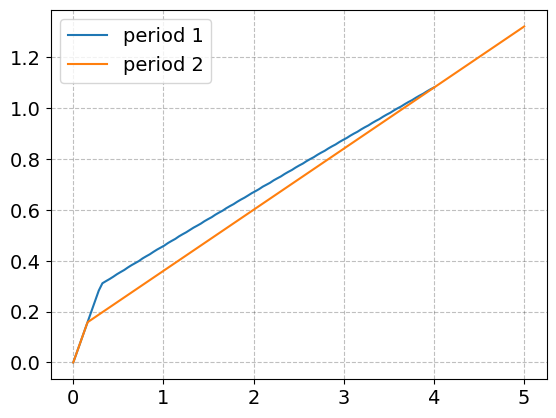

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(model.sol.m1,model.sol.c1,label='period 1')
ax.plot(model.sol.m2,model.sol.c2,label='period 2')
ax.legend();

**.sim:**

In [6]:
for name,value in model.sim.__dict__.items():
    print(f'sim.{name}, with shape = {value.shape}')

sim.m1, with shape = (1000,)
sim.y2, with shape = (1000,)
sim.c1, with shape = (1000,)
sim.a1, with shape = (1000,)
sim.m2, with shape = (1000,)
sim.c2, with shape = (1000,)


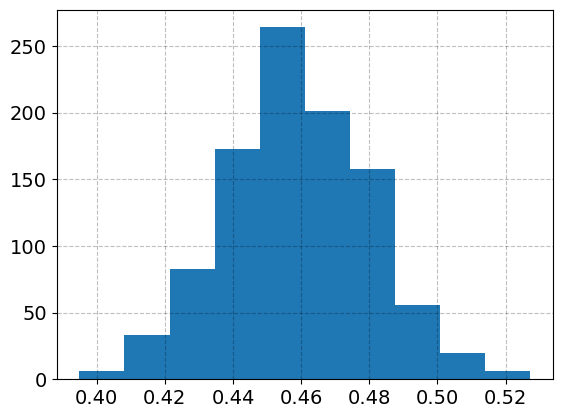

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(model.sim.c1);

## 2. <a id='toc2_'></a>[Simulated Minimum Distance](#toc0_)

**Goal:** We want to estimate the parameter set $\theta = \{\rho\}$.<br>
(We assume all other parameters are known.)

**Data:** We have empirical data so we can caulcate three moments, $\Lambda_{data}$:

1. Mean consumption in period 1 
2. Mean consumption in period 2
3. Mean variance of consumption across periods.

(Note: In pratice, it is tricky how to choose moments. Trial-and-error is required.)

**Model:** We can calculate the same moments, $\Lambda_{model}(\theta)$, as a function of the unknown parameters.


**Basic idea:** *Choose parameter to minimize distance between data and model moments.*

Difference between data and model moments:

$$
g(\theta)=\Lambda_{data}-\Lambda_{model}(\theta)
$$

**Simulated Minimum Distance (SMD)** estimator is then given by

$$
\hat{\theta} = \arg\min_{\theta} g(\theta)'Wg(\theta)
$$

where $W$ is a **weighting matrix**. $W$ is $J \times J$, where $J$ is the number of moments. 

The relative size of elements in $W$ determines the importance of the corresponding moments. In our case:
$$ 
\begin{aligned}
W = 
\begin{bmatrix} 
1 & 0 & 0 \\ 
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix} 
\end{aligned}
$$

#CHR: Each moment weighted identically

## 3. <a id='toc3_'></a>[Data](#toc0_)

**Game plan:**
1. We simulate the model with the "true" parameters.
2. The outcome is our "empirical" data set.
3. We therefore know exactly what our estimation should lead to.

In [8]:
model_true = ConsumptionSavingModelClass()
model_true.solve()
model_true.draw_random_values() # note: different than in model!
model_true.simulate()

## 4. <a id='toc4_'></a>[Estimation](#toc0_)

The function to calculate $\Lambda$ is called `moment_func()`

In [9]:
def moment_func(model):
    """ calculate moments for model"""

    sim = model.sim 
    
    mom1 = sim.c1.mean()
    mom2 = sim.c2.mean()
    mom3 = np.var(np.stack((sim.c1,sim.c2)),axis=0).mean()
    
    return np.array([mom1, mom2, mom3])

Data moments can be calculated:

In [10]:
data_moms = moment_func(model_true)

The function $g(\theta)=\Lambda_{data}-\Lambda_{model}(\theta)$ is called `moments_diff()`

In [11]:
def moments_diff(model, data_moms):
    """ calcualte differences """
    
    # a. solve and simulate
    model.solve()
    model.simulate()

    # b. moments
    moms = moment_func(model)

    # c. difference
    return data_moms - moms 

#CHR: Note we don't call drawradomnumbers, because we want to have a change in moment for a give draw of random numbers

Our objective $g(\theta)'Wg(\theta)$ is in the function `obj_func()` 

In [12]:
def obj_func(x,theta,model,data_moms,W=None,do_print=True):
    """ calculate objective """

    if W is None: W = np.eye(data_moms.size)

    # a. set parameters
    for value,name in zip(x,theta):
        model.par.__dict__[name] = value

    # b. calculate difference
    diff = moments_diff(model, data_moms)

    # c. calculate objective
    obj = diff@W@diff

    # d. print
    if do_print: print(f'{model.par.rho = :12.8f} -> {obj:12.8f}')

    return obj

We are now ready to estimate! Here we use **Nelder-Mead** as the objective function can be rugged, which it handles well.

In [15]:
theta = ['rho']
x0 = np.array([3.0])

res = optimize.minimize(obj_func, x0, 
                            args=(theta,model,data_moms), method='Nelder-Mead')

display(res)

model.par.rho =   3.00000000 ->   0.02806375
model.par.rho =   3.15000000 ->   0.03353119
model.par.rho =   2.85000000 ->   0.02264050
model.par.rho =   2.70000000 ->   0.01731853
model.par.rho =   2.40000000 ->   0.00755540
model.par.rho =   2.10000000 ->   0.00093121
model.par.rho =   1.50000000 ->   0.01979415
model.par.rho =   2.40000000 ->   0.00755540
model.par.rho =   1.80000000 ->   0.00192122
model.par.rho =   1.95000000 ->   0.00004599
model.par.rho =   1.80000000 ->   0.00192122
model.par.rho =   2.02500000 ->   0.00021050
model.par.rho =   1.87500000 ->   0.00056828
model.par.rho =   1.98750000 ->   0.00005175
model.par.rho =   1.91250000 ->   0.00021265
model.par.rho =   1.96875000 ->   0.00002870
model.par.rho =   1.98750000 ->   0.00005175
model.par.rho =   1.95937500 ->   0.00003414
model.par.rho =   1.97812500 ->   0.00003610
model.par.rho =   1.96406250 ->   0.00002983
model.par.rho =   1.97343750 ->   0.00003125
model.par.rho =   1.96640625 ->   0.00002892
model.par.

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.8696963748384622e-05
             x: [ 1.969e+00]
           nit: 16
          nfev: 32
 final_simplex: (array([[ 1.969e+00],
                       [ 1.969e+00]]), array([ 2.870e-05,  2.870e-05]))

In [14]:
print(f'rho_hat = {res.x[0]:1.4f} [true: {model_true.par.rho:1.4f}]')

rho_hat = 1.9686 [true: 2.0000]


**Conclusion:** Close to truth, so seems to work.

**Profile of the objective function**

In [16]:
npoints = 20
rhos = np.linspace(0.5,4.0,npoints)
obj_vals = np.empty((npoints,))
for i,rho in enumerate(rhos):
    obj_vals[i] = obj_func(np.array([rho]),theta,model,data_moms)

model.par.rho =   0.50000000 ->   0.40375232
model.par.rho =   0.68421053 ->   0.30777859
model.par.rho =   0.86842105 ->   0.20273772
model.par.rho =   1.05263158 ->   0.11935904
model.par.rho =   1.23684211 ->   0.06327792
model.par.rho =   1.42105263 ->   0.02928675
model.par.rho =   1.60526316 ->   0.01070390
model.par.rho =   1.78947368 ->   0.00218621
model.par.rho =   1.97368421 ->   0.00003148
model.par.rho =   2.15789474 ->   0.00180226
model.par.rho =   2.34210526 ->   0.00594184
model.par.rho =   2.52631579 ->   0.01144389
model.par.rho =   2.71052632 ->   0.01768233
model.par.rho =   2.89473684 ->   0.02422845
model.par.rho =   3.07894737 ->   0.03090246
model.par.rho =   3.26315789 ->   0.03748025
model.par.rho =   3.44736842 ->   0.04383598
model.par.rho =   3.63157895 ->   0.05003774
model.par.rho =   3.81578947 ->   0.05613185
model.par.rho =   4.00000000 ->   0.06163344


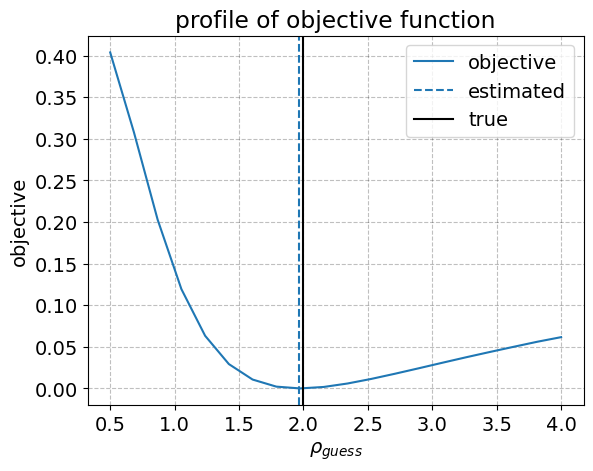

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(rhos,obj_vals,label='objective')

ax.axvline(res.x,label='estimated',ls='--')
ax.axvline(model_true.par.rho,label='true',color='black')

ax.set_xlabel(r'$\rho_{guess}$')
ax.set_ylabel('objective')

ax.set_title(r'profile of objective function')
ax.legend();

**Task:** If you run everything with a higher `par.simN` the estimated value will be closer to the true one.

1. Higher number of consumers when constructing data.
2. Higher number of consumers when simulating model.

## 5. <a id='toc5_'></a>[Perspectives](#toc0_)

**Choosing moments:**

1. Fitting more moments is generally always better.
2. If the objective is flat in a parameter, it is not identified from the moments.

**Standard errors:** Can be calculated based on the derivatives of the objective function.
<br>Covered in e.g. [Household Behavior 
over the Life Cycle](https://sites.google.com/view/householdbehavior/home).